# Klassifikation der Bezierke nach Meeresnähe

Die Fragestellung, das Problem:

**Wir wollen in Zukunft die Nähe der Häuserblöcke zum Meer bestimmen. Dazu wollen wir ein Klassificationsmodel trainieren, welches die Häuserblöcke den vordefinierten Abstandskategorien zuordnet.**

In diesem Beispiel verwenden wir dazu KNN-Classifier

## K-Neightbors-Klassifikation

In [1]:
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns 
sns.set()

### Einlesen und Visualisierung der Daten

In [2]:
data = pd.read_csv("../data/housing.csv")
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


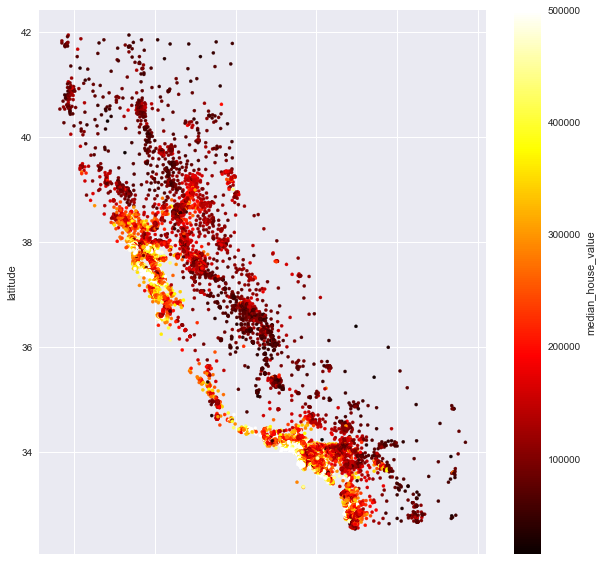

In [3]:
data.plot.scatter(x='longitude', y='latitude', c='median_house_value', s=10, cmap='hot', figsize=(10,10));

### Teile den Datensatz in Train und Test

In [4]:
cleaned_data = data.dropna()

In [5]:
X = cleaned_data.drop('ocean_proximity', axis=1)
y = cleaned_data['ocean_proximity'].values

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [7]:
X_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
5693,-118.25,34.23,35.0,2839.0,592.0,1413.0,538.0,4.1667,271200.0
18136,-122.00,37.35,20.0,4304.0,851.0,2059.0,835.0,5.1674,333000.0
14589,-117.19,32.83,30.0,3225.0,555.0,1601.0,532.0,4.3317,173300.0
3144,-118.19,35.05,14.0,2992.0,573.0,1631.0,526.0,3.7452,83200.0
13316,-117.62,34.07,16.0,6009.0,1599.0,5110.0,1389.0,2.5677,128900.0


### Vorverarbeitung der Datansätze

#### Kategorien der Zielvariablen y in Zahlen konvertieren

In [8]:
pd.DataFrame(y_train[0:5])

,0
0,<1H OCEAN
1,<1H OCEAN
2,NEAR OCEAN
3,INLAND
4,INLAND


Wandle die Kategorien in Nummern um:

In [9]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y_train)

LabelEncoder()

In [10]:
y_train = le.transform(y_train)
y_test = le.transform(y_test)

In [11]:
y_train

array([0, 0, 4, ..., 0, 3, 0])

In [12]:
y_test

array([1, 3, 1, ..., 1, 1, 1])

#### Skalierung der Feature

In [13]:
min_max_scaler = preprocessing.MinMaxScaler()


Wir fitten den Scaler nur mit den Trainingsdaten

In [14]:
min_max_scaler.fit(X_train)

MinMaxScaler(copy=True, feature_range=(0, 1))

Und wenden ihn dann auf Train und Test an:

In [15]:
X_train = min_max_scaler.transform(X_train)
X_test = min_max_scaler.transform(X_test)

### Baue den Klassifizierer

In [16]:
from sklearn.neighbors import KNeighborsClassifier

In [17]:
k = 5
knn = KNeighborsClassifier(k)

#### Training

In [18]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

Nun haben wir unser Modell und wollen es testen

### Verwende den Klassifier und werte ihn aus

In [19]:
y_pred_train = knn.predict(X_train)
y_pred_test = knn.predict(X_test)

---

#### Auswertung

Da wir die Kategorien in Zahlen umgewandelt haben, wäre es zwar möglich einen Abstand zwischen den einzelnen Kategorien zu bilden, wenn diese aber nicht sortiert sind macht dies keinen Sinn. Einen Abstand zwischen der Klasse "rot" und "blau", könnte ich zwar berechnen wenn man "rot" den index 1 zugewiesen hat und "blau" den index 2, das Ergebnis hat jedoch keine weitere Bedeutung. Aus diesem Grund sind Fehlermaße die auf der Differenz basieren für die Klassifizierung nicht geeignet.

Eine Möglichkeit ist die Bewertung des Ergebnisses indem wir uns anschauen wieviele Häuserblöcke der falschen/richtigen Kategorie hinzugefügt wurden.

---

**Dazu folgender kleiner #devtrick, um die Anzahl der falsch zugeordneten Häuserblöcke zu ermitteln:**

Das Vergleichen von zwei Vektoren mit dem ungleich-Operator '!=' liefert einen boolschen Wert für jede Zeile

In [20]:
(y_train != y_pred_train)

array([False, False, False, ..., False, False, False])

Der Trick ist nun diese einfach mit 1 zu multiplizieren

In [21]:
1 * (y_train != y_pred_train)

array([0, 0, 0, ..., 0, 0, 0])

so erhalten wir ein Array in dem für jeden True-Wert eine 1 und jeden False-Wert eine 0 steht. Damit können wir wieder Rechnen!

In [22]:
print('Anzahl der Fehlklassifizierungen: ', (1 * (y_train != y_pred_train)).sum())
print('Rate der Fehlklassifizierungen: ', (1 * (y_train != y_pred_train)).mean())

Anzahl der Fehlklassifizierungen:  1556
Rate der Fehlklassifizierungen:  0.11365960555149744


---

**Genauigkeit (Der richtigen Kategorie zugeordnet)**

In [23]:
# Trainingsdatensatz
classification_accuracy_train = 1 * (y_train == y_pred_train).mean()
classification_accuracy_train

0.8863403944485025

In [24]:
# Testdatensatz
classification_accuracy_test = 1 * (y_test == y_pred_test).mean()
classification_accuracy_test

0.8367195610262494

**Klassifizierungsfehler (Der falschen Kategorie zugeordnet)**

In [25]:
# Trainingsdatensatz
missclassification_train = 1*(y_train != y_pred_train).mean()
missclassification_train

0.11365960555149744

In [26]:
# Testdatensatz
missclassification_test = 1 * (y_test != y_pred_test).mean()
missclassification_test

0.16328043897375055

**In Relation: Wenn wir davon ausgehen, dass jede Klasse gleich wahrscheinlich ist, und wenn wir die Klassen zufällig zuordnen würden, wäre unsere Trefferquote 1/(Anzahl der Klassen). Wir würden also nur** 

In [27]:
1 / cleaned_data['ocean_proximity'].nunique()

0.2

**der Häuserblöcke zufällig richtig klassifizieren! Wir sind also besser als der Zufall!**

### Missklassifikation für verschiedene K

In [28]:
train_errors = []
test_errors = []

for k in range(1,50):
    knn_iterated = KNeighborsClassifier(k)
    # Training
    knn_iterated.fit(X_train, y_train)
    
    # Predict
    y_k_predict = knn_iterated.predict(X_train)
    #print("Trainingsfehler: ", (1.0 * (y_train != y_k_predict)).sum()/len(y_train))
    train_errors.append((1.0 * (y_train != y_k_predict)).mean())

    y_k_predict = knn_iterated.predict(X_test)
    #print("Testfehler: ", (1.0 * (y_test != y_k_predict)).sum()/len(y_test))
    test_errors.append((1.0 * (y_test != y_k_predict)).mean())


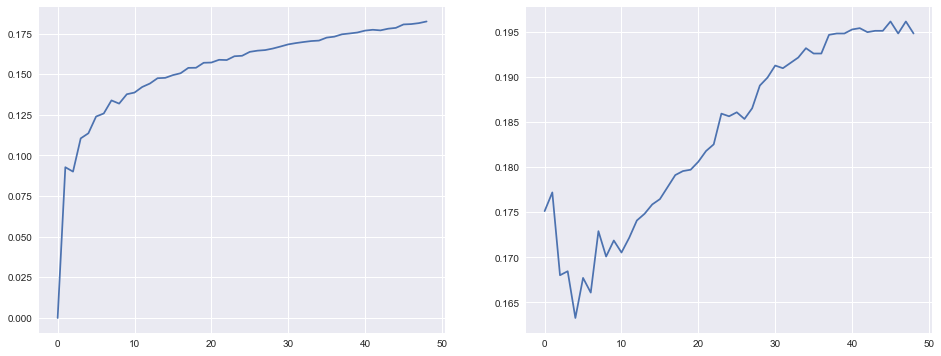

In [29]:
plt.figure(1, figsize=(16, 6))
plt.subplot(1,2,1)
plt.plot(train_errors)
plt.subplot(1,2,2)
plt.plot(test_errors);

---

**Aufgaben**
- Wie sieht die Klassifizierungsfehler pro Klasse aus?
- Wir können ein geeignetes K mittels der Klassifizierungsfehler bestimmen. Dies wird oben gemacht, allerdings mit den Testdaten. Teile die Daten in Train, Validate und Test und bestimme mittels des Validate Datensatzes ein geeignetes K. Wie unterscheidet sich der Validate-Fehler vom Test-Fehler für dieses K?
- Kann ich durch weglassen von Featuren vielleicht meine Vorhersage verbessern?
- Kann ich durch eine andere Skalierung der Feature meine Vorhersage verbessern?